In [3]:
#import needed packages

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import time
import pandas as pd
from ecp import e_divisive, e_agglomerative
%matplotlib inline

In [41]:
data = pd.read_csv("fret_data/binned_ms_4.txt", sep=",")
spl = 500

# d1 = data['n_accept']
# d2 = data['n_donor']
# ts = data['effi']

# plt.figure(figsize=(20,10))
# plt.plot(d1)
# plt.plot(d2)
# plt.figure(figsize=(20,10))
# plt.plot(ts)


d1 = data['n_accept'][:spl]
d2 = data['n_donor'][:spl]
ts = data['effi'][:spl]
new_ts = np.stack((d1, d2), axis=-1)
# plt.figure(figsize=(20,10))
# plt.plot(new_ts)
# plt.plot(d1)
# plt.plot(d2)
# plt.figure(figsize=(20,10))
# plt.plot(ts)

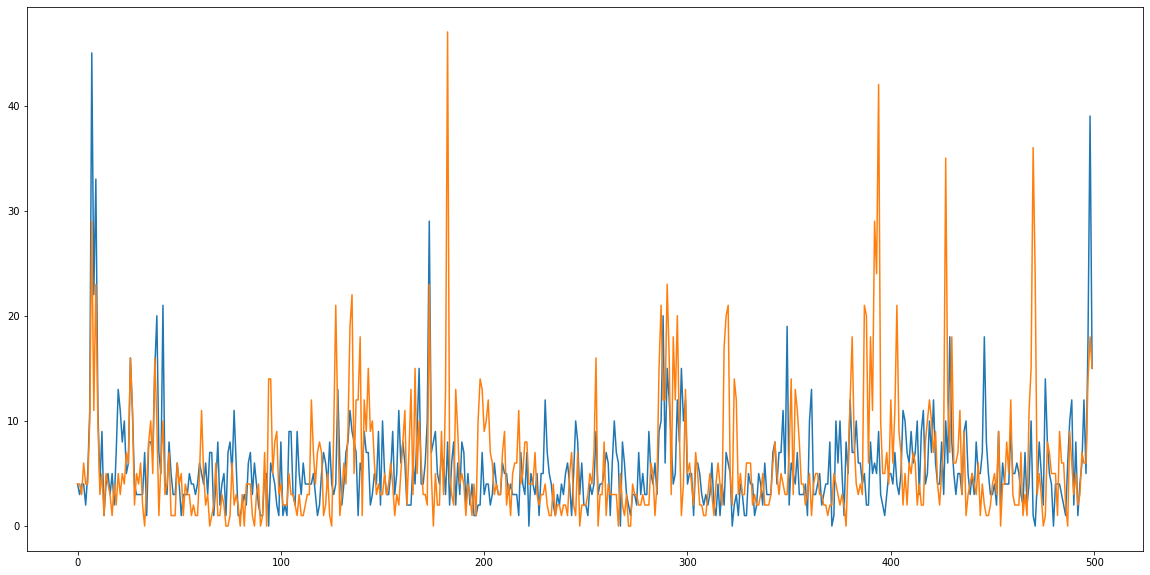

In [42]:
plt.figure(figsize=(20,10))
plt.plot(new_ts)

# t1 = time.time()
# sol_dict = e_divisive.e_divisive(X = new_ts, k = 50, alpha=2, min_size=2)
# t2 = time.time()
# print("Estimated Number of Change Points: " + str(K))
# print("Minimum Size before Change: " + str(ms))
# print("Time: ", t2-t1)
# print("Found Change Points: " + str(len(sol_dict['estimates'])-2))
# for xc in sol_dict['estimates']:
#     plt.axvline(x=xc, color='r', linestyle=':')

Estimated Number of Change Points: 100
Minimum Size before Change: 10
Time:  1.753939151763916
Found Change Points: 42


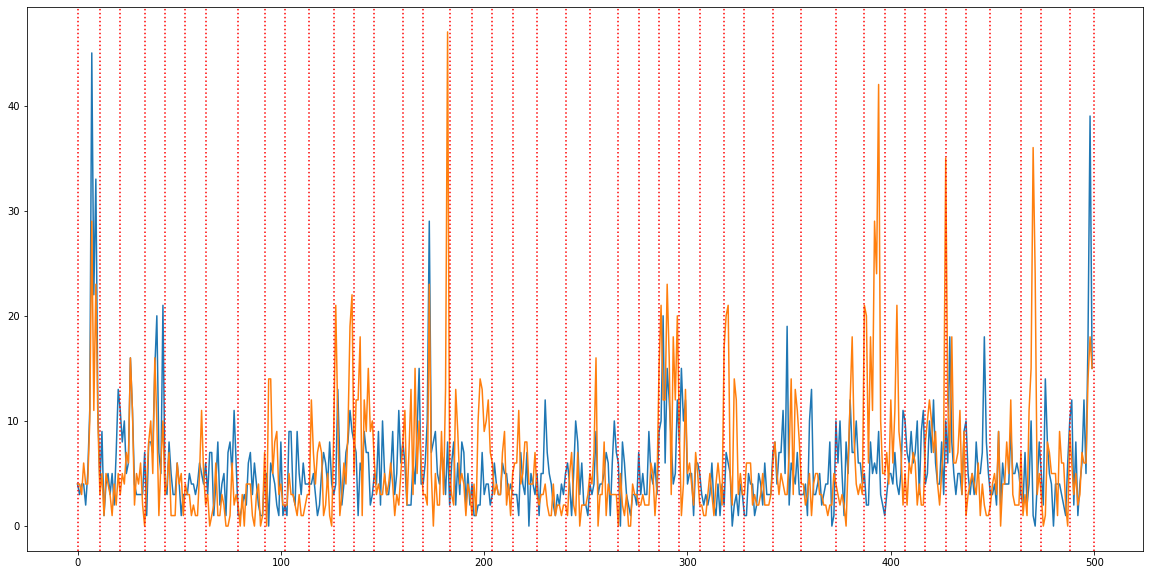

In [57]:
spl = 500
ts1 = data['n_accept'][:spl]
ts2 = data['n_donor'][:spl]
ts = np.column_stack((ts1, ts2))
# ts = data['effi'][:spl].to_numpy()




plt.figure(figsize=(20,10))
plt.plot(ts)

ms = 10
K = 100 #Number of Change Points for e_divisive
num_of_states = 5 #Number of final states for e_agglo

t1 = time.time()
# sol_dict = e_divisive.e_divisive(X = np.reshape(ts, (len(ts), 1)), k=K, alpha=2, min_size=ms)
sol_dict = e_divisive.e_divisive(X = ts, k=K, alpha=2, min_size=ms)
t2 = time.time()
print("Estimated Number of Change Points: " + str(K))
print("Minimum Size before Change: " + str(ms))
print("Time: ", t2-t1)
print("Found Change Points: " + str(len(sol_dict['estimates'])-2))
for xc in sol_dict['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')

In [58]:
def get_within(alpha, X):
    alpha = float(alpha)
    ret = 0.0
    
    n = X.shape[0]
    
    for i in range(n):
        for j in range(n):
            ret += np.power(np.sqrt(np.sum((X[i, :] - X[j, :]) * (X[i, :] - X[j, :]))), alpha)
    return ret/(n*n) if (n*n) != 0 else np.nan

def get_between(alpha, X, Y):
    alpha = float(alpha)
    ret = 0.0
    
    n = X.shape[0]
    m = Y.shape[0]
    
    for i in range(n):
        for j in range(m):
            ret += np.power(np.sqrt(np.sum((X[i, :] - Y[j, :]) * (X[i, :] - Y[j, :]))), alpha)
    return (2*ret)/float(n*m) if (n*m) != 0 else np.nan

def agglo_method(alpha, n, ts, cluster, k):
    ret = {"order": [], "cluster": cluster}
    curr_n = n
    if curr_n <= k:
        return ret
    
    within = np.zeros(n)
    for i in range(n):
        working_ts = ts[cluster==i]
        if working_ts.ndim == 1: working_ts = np.reshape(working_ts, (len(working_ts), 1))
        within[i] = get_within(alpha, working_ts)

    dflat = np.zeros(int(((n*n)-n)/2))
    idx = 0
    md = [] #maps from the linear index to the tuple (i, j) in the non-flattened distance matrix

    for i in range(n):
        for j in range(i+1, n):
            working_ts1 = ts[cluster==i]
            working_ts2 = ts[cluster==j]
            if working_ts1.ndim == 1: working_ts1 = np.reshape(working_ts1, (len(working_ts1), 1))
            if working_ts2.ndim == 1: working_ts2 = np.reshape(working_ts2, (len(working_ts2), 1))
            d = get_between(alpha, working_ts1, working_ts2) - within[i] - within[j]
            dflat[idx] = d
            idx += 1
            md.append((i, j))
    while(curr_n > k):
        min_idx = np.nanargmin(dflat)
        i, j = md[min_idx]
        ret["order"].append((i, j))
        
        
        cluster[cluster==j] = i
        working_ts = ts[cluster == i]
        if working_ts.ndim == 1: working_ts = np.reshape(working_ts, (len(working_ts), 1))
        new_within = get_within(alpha, working_ts)
        within[i] = new_within
        within[j] = new_within
        
        for idx in range(n):
            if idx != j and idx != i:
                working_ts1 = ts[cluster==i]
                working_ts2 = ts[cluster==idx]
                if working_ts1.ndim == 1: working_ts1 = np.reshape(working_ts1, (len(working_ts1), 1))
                if working_ts2.ndim == 1: working_ts2 = np.reshape(working_ts2, (len(working_ts2), 1))
                d = get_between(alpha, working_ts1, working_ts2) - within[i] - within[idx]
                
                if idx < i:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*i) - (3*idx) - 2)/2)
                    dflat[flat_idx] = d
                elif idx > i:
                    flat_idx = int(((2*i*n) - (i*i) + (2*idx) - (3*i) - 2)/2)
                    dflat[flat_idx] = d
                    
                if idx < j:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*j) - (3*idx) - 2)/2)
                    dflat[flat_idx] = np.inf
                elif idx > j:
                    flat_idx = int(((2*j*n) - (j*j) + (2*idx) - (3*j) - 2)/2)
                    dflat[flat_idx] = np.inf
            elif idx == j:
                t1, t2 = (i, j) if i < j else (j, i)
                flat_idx = int(((2*t1*n) - (t1*t1) + (2*t2) - (3*t1) - 2)/2)
                dflat[flat_idx] = np.inf  
                
                flat_idx = int(((2*t2*n) - (t2*t2) + (2*t1) - (3*t2) - 2)/2)
                dflat[flat_idx] = np.inf
        curr_n = len(np.unique(cluster))
    ret["cluster"] = cluster
    return ret

In [59]:
point_labels = agglo_method(alpha=2, n=len(sol_dict['estimates'])-1, ts=np.copy(ts), cluster=np.copy(sol_dict['cluster']), k=num_of_states)["cluster"]
final_ests = [sol_dict['estimates'][0]]
seg_labels = [point_labels[0]]
for i in range(1, len(point_labels)):
    if point_labels[i] != point_labels[i-1]:
        final_ests.append(i)
        seg_labels.append(point_labels[i])
final_ests.append(sol_dict['estimates'][-1])
final_ests = np.array(final_ests)
seg_labels = np.array(seg_labels)
print("State Labels for each Point: ")
print(point_labels)
print()
print("Segment Estimates: ")
print(final_ests)
print()
print("Segment Labels: ")
print(seg_labels)

State Labels for each Point: 
[ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  8  8  8  8
  8  8  8  8  8  8  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  1  1  1  1  1  1  1  1  1  1  1  1  1  1  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  1  1  1  1  1  1  1  1  1
  1  1  8  8  8  8  8  8  8  8  8  8  1  1  1  1  1  1  1  1  1  1  8  8
  8  8  8  8  8  8  8  8  8  8  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 25 25
 25 25 25 25 25 25 25 25  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  8

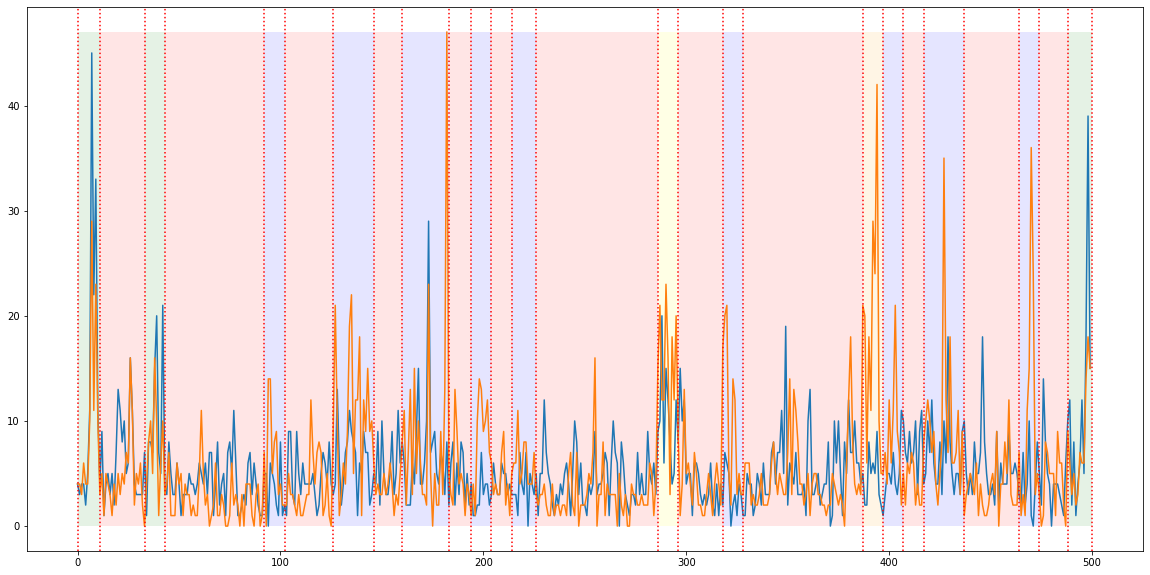

In [60]:
plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in final_ests:
    plt.axvline(x=xc, color='r', linestyle=':')

mx = np.max(ts)    
diff_labs = np.unique(seg_labels)
for i in range(len(seg_labels)):
    if seg_labels[i] == diff_labs[0]:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='green', alpha=0.10)
    elif seg_labels[i] == diff_labs[1]:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='red', alpha=0.10)
    elif seg_labels[i] == diff_labs[2]:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='blue', alpha=0.10)
    elif seg_labels[i] == diff_labs[3]:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='yellow', alpha=0.10)
    else:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='orange', alpha=0.10)

In [61]:
lens = np.diff(final_ests)
find_avg_time = np.vectorize(lambda x : np.mean(lens[seg_labels == x]))
avg_times = find_avg_time(np.unique(seg_labels))

print("Average length for each state before transitioning: ")
print(avg_times) #P_{i, i} = (x - 1)/x
print()
P_diag = np.vectorize(lambda x : (x - 1)/x)(avg_times)

print("Corresponding Probabilities: ")
print(P_diag)

Average length for each state before transitioning: 
[11.         26.83333333 13.88888889 10.         10.        ]

Corresponding Probabilities: 
[0.90909091 0.96273292 0.928      0.9        0.9       ]


In [62]:
est_P = np.zeros((num_of_states, num_of_states))
fixed_labels = np.copy(seg_labels)
unq = np.unique(seg_labels)
for i in range(len(unq)):
    fixed_labels[fixed_labels == unq[i]] = i
print(fixed_labels)
for i in range(1, len(seg_labels)):
    est_P[fixed_labels[i-1], fixed_labels[i]] += 1
np.fill_diagonal(est_P, 0)
est_P = normalize(est_P, axis = 1, norm='l1')
est_P = (est_P.T*(1 - P_diag)).T
np.fill_diagonal(est_P, P_diag)
print("Estimated Transition Matrix: ")
print(est_P)

[0 1 0 1 2 1 2 1 2 1 2 1 2 1 3 1 2 1 4 2 1 2 1 2 1 0]
Estimated Transition Matrix: 
[[0.90909091 0.09090909 0.         0.         0.        ]
 [0.00621118 0.96273292 0.02484472 0.00310559 0.00310559]
 [0.         0.072      0.928      0.         0.        ]
 [0.         0.1        0.         0.9        0.        ]
 [0.         0.         0.1        0.         0.9       ]]


Estimated P: 
[[0.90909091 0.09090909 0.         0.         0.        ]
 [0.00621118 0.96273292 0.02484472 0.00310559 0.00310559]
 [0.         0.072      0.928      0.         0.        ]
 [0.         0.1        0.         0.9        0.        ]
 [0.         0.         0.1        0.         0.9       ]]

Point Labels: 
[ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  8  8  8  8
  8  8  8  8  8  8  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  1  1  1  1  1  1  1  1  1  1  1  1  1  1  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  1  1  1  1  1  1  1  1  1
  1  1  8  8  8  8  8  8  8  8  8  8  1  1  1  1  1  1  1  1  1  1  8  8
  8  8  8  8  8  8  8 

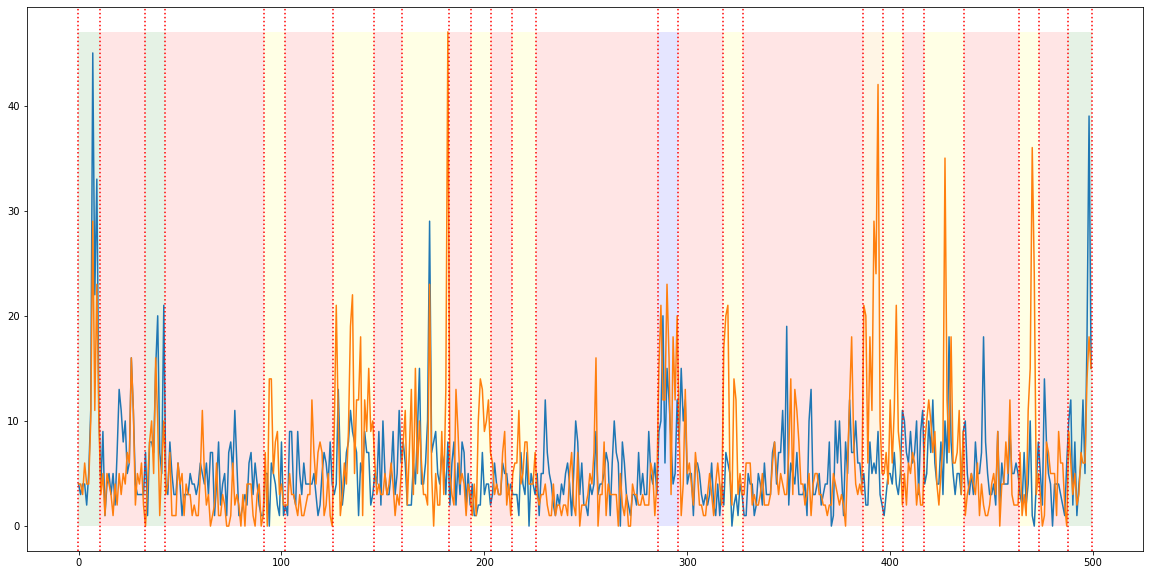

In [63]:
#Final Solution:
plt.figure(figsize=(20,10))
plt.plot(ts)
final_ests = final_ests - 0.5
for xc in final_ests:
    plt.axvline(x=xc, color='r', linestyle=':')
mx = np.max(ts)
diff_labs = np.unique(seg_labels)
for i in range(len(seg_labels)):
    if seg_labels[i] == diff_labs[0]:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='green', alpha=0.10)
    elif seg_labels[i] == diff_labs[1]:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='red', alpha=0.10)
    elif seg_labels[i] == diff_labs[2]:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='yellow', alpha=0.10)
    elif seg_labels[i] == diff_labs[3]:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='blue', alpha=0.10)
    else:
        plt.fill_betweenx([0, mx], final_ests[i], final_ests[i+1], facecolor='orange', alpha=0.10)

print("Estimated P: ")
print(est_P)
print()
print("Point Labels: ")
print(point_labels)
print()
print("Segment Labels: ")
print(seg_labels)

In [28]:
# np.savetxt(sys.stdout, est_P, '%5.2f')

 0.66  0.28  0.06  0.00
 0.11  0.82  0.07  0.00
 0.09  0.28  0.63  0.00
 0.44  0.00  0.00  0.56
